In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset,DataLoader

from zipfile import ZipFile
import cv2
import gc
import os

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os

os.environ["KAGGLE_API_TOKEN"] = "KGAT_0d576b13316b02d8d5a4439cddcec9a3"


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ashweljohn","key":"7e08ce6675f961acca7d13e0e0806aa2"}'}

In [ ]:
!mkdir -p /root/.config/kaggle
!mv kaggle.json /root/.config/kaggle/
!chmod 600 /root/.config/kaggle/kaggle.json


In [ ]:
!kaggle -v


Kaggle API 1.7.4.5


In [ ]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
 95% 1.68G/1.76G [00:18<00:02, 38.9MB/s]
100% 1.76G/1.76G [00:18<00:00, 101MB/s] 


In [ ]:
from zipfile import ZipFile

with ZipFile("lung-and-colon-cancer-histopathological-images.zip", "r") as zip_ref:
    zip_ref.extractall("data")

print("Dataset extracted successfully ✅")


Dataset extracted successfully ✅


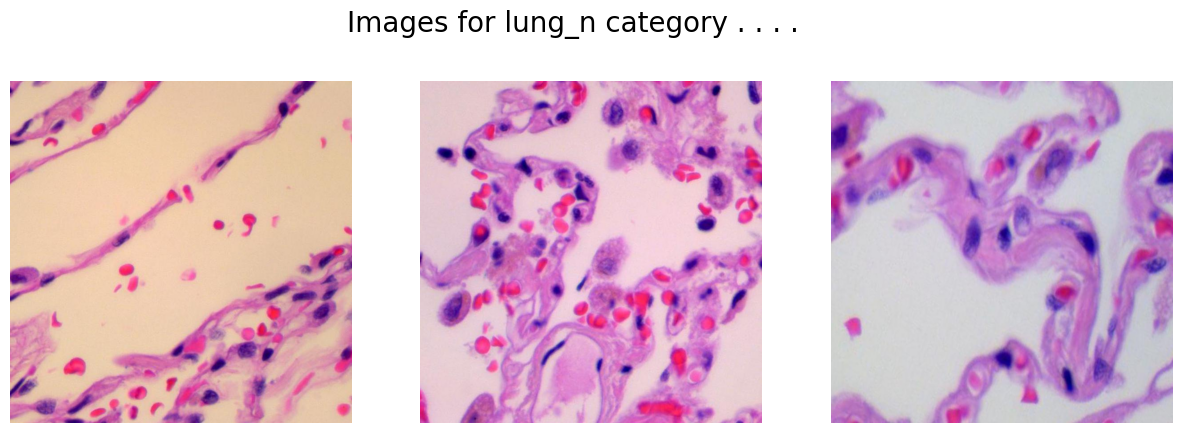

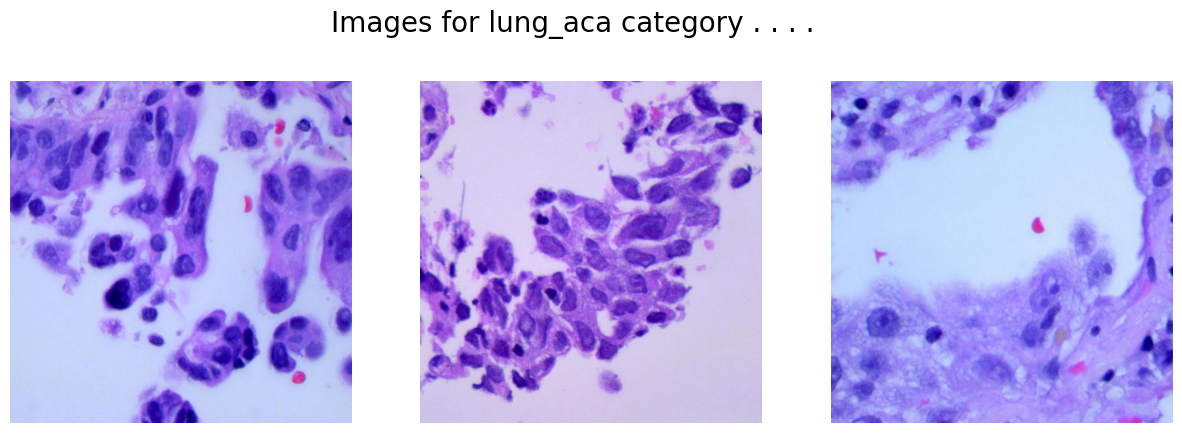

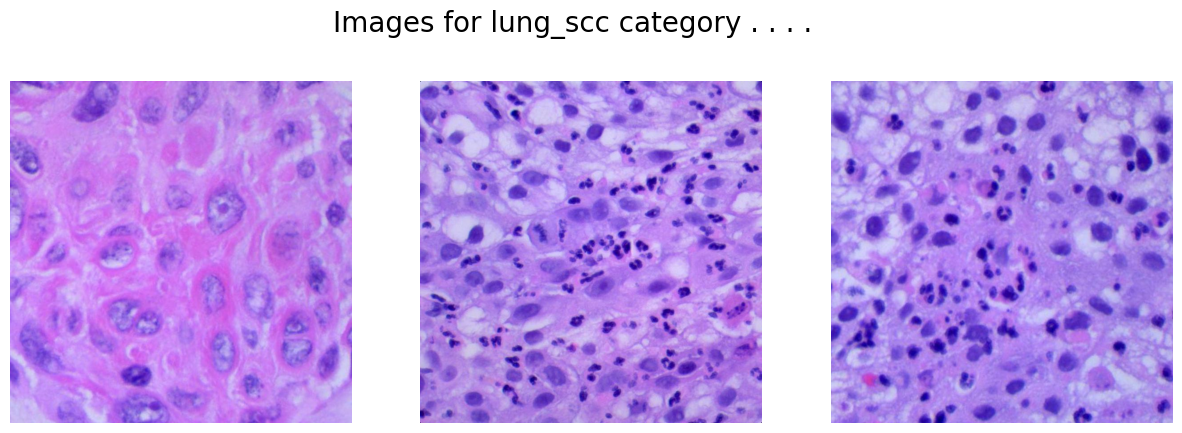

In [ ]:
torch.manual_seed(42)
classes = ['lung_n', 'lung_aca', 'lung_scc']

path = '/content/data/lung_colon_image_set/lung_image_sets'

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{image_dir}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')

    plt.show()


In [ ]:
IMG_SIZE = 256
EPOCHS = 10
SPLIT = 0.2
BATCH_SIZE = 32

X = []
Y = []

# -------- Load images --------
for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')

    for image in images:
        img = cv2.imread(image)

        if img is not None:  # safety check
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            Y.append(i)

# -------- Convert to arrays --------
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

# -------- Train-test split --------
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    one_hot_encoded_Y,
    test_size=SPLIT,
    random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 12000
Testing samples: 3000


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LungCancerCNN(nn.Module):
    def __init__(self, img_size=256, num_classes=3):
        super().__init__()

        # ---- Convolution blocks ----
        self.conv1 = nn.Conv2d(
            in_channels=3,        # RGB images
            out_channels=32,
            kernel_size=5,
            padding=2
        )
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            padding=1
        )

        self.conv3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=3,
            padding=1
        )

        self.flatten = nn.Flatten()

        # ---- Fully connected layers ----
        fc_input_size = 128 * (img_size // 8) * (img_size // 8)

        self.fc1 = nn.Linear(fc_input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)

        self.dropout = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.bn1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.bn2(x)

        x = self.fc3(x)  # logits
        return x


In [ ]:
model = LungCancerCNN(
    img_size=IMG_SIZE,
    num_classes=3
)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001
)


In [ ]:
class EarlyStopByAccuracy:
  def __init__(self,threshold=0.90):
    self.threshold=threshold

  def __call__(self,val_acc):
    if val_acc>=self.threshold:
      print(f"\nValidation accuracy reached {val_acc:.2f}. Stopping training.")
      return True
    return False

In [ ]:
class EarlyStopping:
  def __init__(self,patience=3):
    self.patience=patience
    self.counter=0
    self.best_score=None
    self.early_stop=False

  def __call__(self,val_acc):
    if self.best_score is None or val_acc > self.best_score:
      self.best_score=val_acc
      self.counter=0
    else:
      self.counter+=1
      if self.counter>=self.patience:
        print("Early stopping triggered.")
        self.early_stop=True

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=2,
    factor=0.5,
)


In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [ ]:
from torchvision.datasets import ImageFolder

train_dir = "/content/data/lung_colon_image_set/lung_image_sets"

train_dataset = ImageFolder(
    root=train_dir,
    transform=train_transform
)

val_dataset = ImageFolder(
    root=train_dir,
    transform=val_transform
)


In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 32

from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}


In [ ]:
for epoch in range(EPOCHS):

    # -------- TRAINING --------
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss /= len(train_loader)
    train_acc = correct / total

    # -------- VALIDATION --------
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total

    # -------- SAVE HISTORY --------
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # -------- PRINT RESULTS --------
    print(
        f"Epoch [{epoch+1}/{EPOCHS}] "
        f"Train Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )


Epoch [1/10] Train Loss: 0.1418 | Train Acc: 0.9473 | Val Loss: 0.0871 | Val Acc: 0.9682
Epoch [2/10] Train Loss: 0.1304 | Train Acc: 0.9509 | Val Loss: 0.4000 | Val Acc: 0.9705
Epoch [3/10] Train Loss: 0.1235 | Train Acc: 0.9532 | Val Loss: 0.1852 | Val Acc: 0.9774
Epoch [4/10] Train Loss: 0.1176 | Train Acc: 0.9555 | Val Loss: 0.1554 | Val Acc: 0.9671
Epoch [5/10] Train Loss: 0.1044 | Train Acc: 0.9608 | Val Loss: 0.2134 | Val Acc: 0.9298
Epoch [6/10] Train Loss: 0.1085 | Train Acc: 0.9612 | Val Loss: 10925.9648 | Val Acc: 0.8822
Epoch [7/10] Train Loss: 0.0956 | Train Acc: 0.9650 | Val Loss: 12.5221 | Val Acc: 0.9533
Epoch [8/10] Train Loss: 0.0884 | Train Acc: 0.9687 | Val Loss: 12.4754 | Val Acc: 0.9693
Epoch [9/10] Train Loss: 0.0735 | Train Acc: 0.9748 | Val Loss: 14.9895 | Val Acc: 0.9910
Epoch [10/10] Train Loss: 0.0653 | Train Acc: 0.9762 | Val Loss: 0.0439 | Val Acc: 0.9857


In [ ]:
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["val_acc"], label="Val Accuracy")
plt.legend()
plt.show()


NameError: name 'history' is not defined